# Extraction and exploration of Cognite OID

Sensor name    Frame length   Sample rate [s]
PDT-92534      (662170, 1)         1.016          
PT-92523       (562911, 1)         1.016          
TIC-92504      (536386, 1)         2.0            
TT 92532       (59703, 1)          5.0            
FT-92537       (758585, 1)         1.016          
TT-92539       (112266, 1)         18.0           
PT-92539       (531158, 1)         2.0            
ZT 92543       (103063, 1)         10.0           
KA 9101        (147219, 1)         5.0            


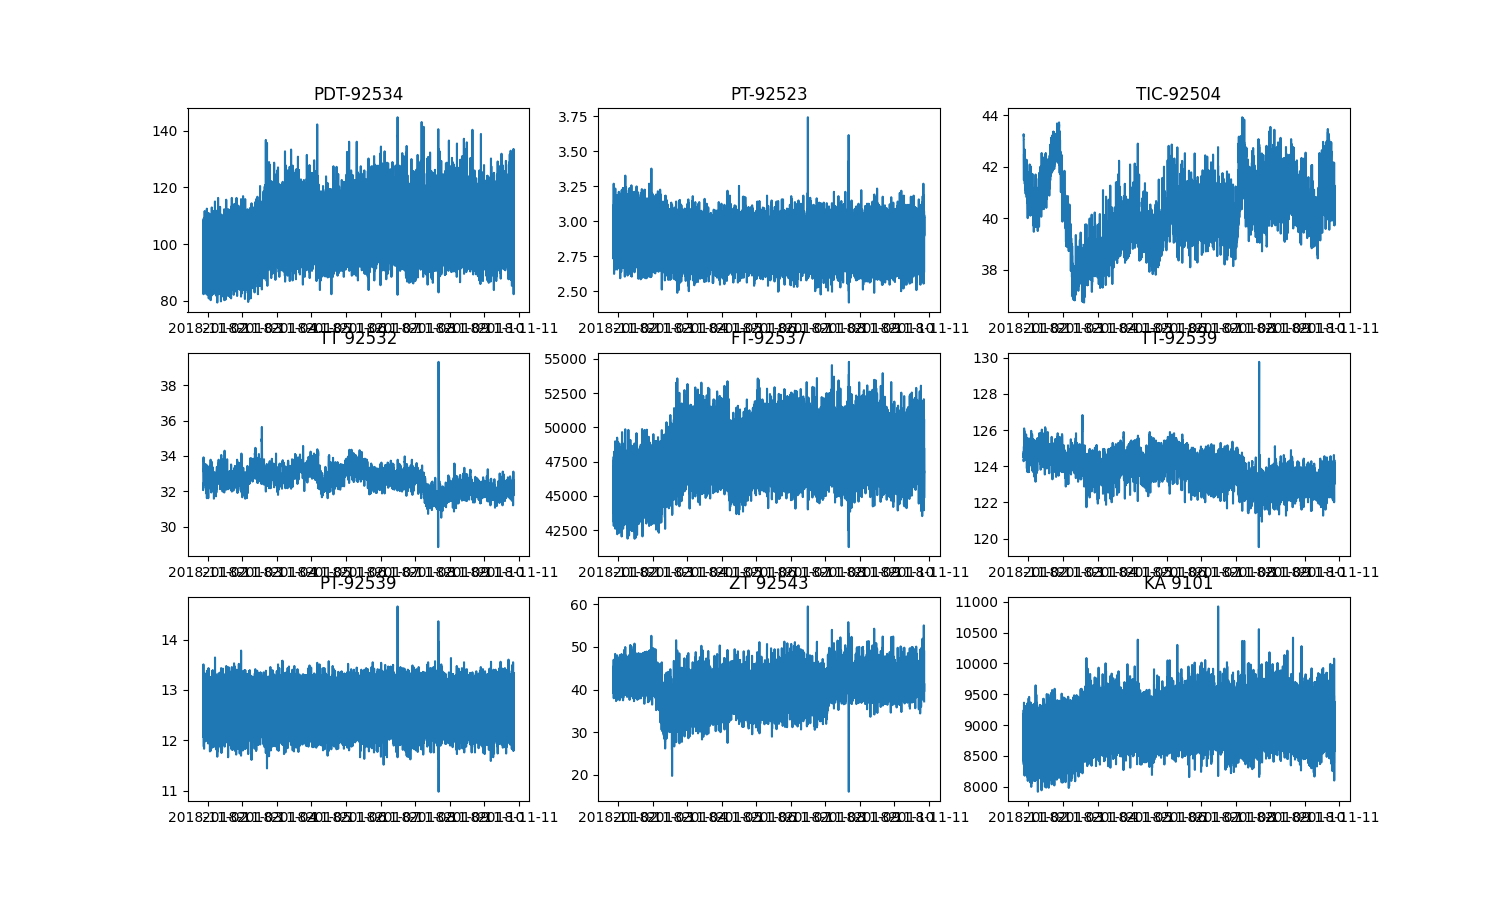

In [2]:
from publicdata import client as c
from functions import *
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget

# Nine sensors related to the inputs, outputs and controls of a compressor subsystem.
# Dictionary made with key=name of sensor and value=Id of sensor
sensors = {
    'PDT-92534': 6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':3278479880462408,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}
# I'll extract a pandas dataframe for each of the sensors in sensor_names, and these will be stored
# in the following dictionary, again with the sensor name as the key.
dfs_dict = {}

startdate = datetime(2018, 11, 1)
enddate = datetime(2018, 11, 10)
today = datetime.today()
days_since_start = (today - startdate).days
days_since_end = (today - enddate).days
starttime = f'{days_since_start}d-ago' # Start time of the interval I want to extract
endtime = f'{days_since_end}d-ago' # End time of the interval I want to extract

print("Sensor name".ljust(15) + "Frame length".ljust(15) + "Sample rate [s]".ljust(15))

# Extract dataframes from Cognite OID and store them in the dfs_dict dictionary
for k, v in sensors.items():
    res = c.time_series.data.retrieve_dataframe(id=v, 
                                                start=starttime, 
                                                end=endtime, 
                                                column_names='id')
    # Need to find a way to grab the unit of the time-series
    dfs_dict[k] = res
    sr = (res.index[1] - res.index[0]).total_seconds()
    # print(f'{k}\'s shape: {res.shape} and sampling frequency: {sr} second(s)')
    print(str(k).ljust(15) + str(res.shape).ljust(20) + str(sr).ljust(15))



# plot_sensor_data('PT-92523', dfs_dict)
plot_all_nine_sensors(dfs_dict)


### Simple inspection of the data

In [9]:
# print((dfs_dict["ZT 92543"].index[1] - dfs_dict["ZT 92543"].index[0]).total_seconds())

print("Name".ljust(12) + "First period".ljust(15) + "Second period".ljust(15) + "Third period".ljust(15) + "Average period".ljust(15))
for name, df in dfs_dict.items():
    f_per = (df.index[1] - df.index[0]).total_seconds()
    second_per = (df.index[2] - df.index[1]).total_seconds()
    third_per = (df.index[3] - df.index[2]).total_seconds()
    avg_per = ((df.index[-1] - df.index[0])/df.shape[0]).total_seconds()
    print(name.ljust(12) + str(f_per).ljust(15) + str(second_per).ljust(15) + str(third_per).ljust(15) + str(avg_per).ljust(15))


Name        First period   Second period  Third period   Average period 
PDT-92534   1.016          1.0            1.984          1.17432        
PT-92523    1.016          0.984          1.0            1.3813849999999999
TIC-92504   2.0            0.984          2.0            1.449699       
TT 92532    5.0            15.0           15.0           13.024288      
FT-92537    1.016          0.984          1.0            1.025064       
TT-92539    18.0           1.016          1.0            6.926215       
PT-92539    2.0            0.984          1.0            1.463968       
ZT 92543    10.0           5.0            20.0           7.544842       
KA 9101     5.0            5.0            5.0            5.281886       


### Standardizing the data

PDT-92534: Avg: 105.39073837968809 Std: 6.198090474461739 Shape: (662111, 1)
PT-92523: Avg: 2.876738865653554 Std: 0.09507616272399828 Shape: (562639, 1)
TIC-92504: Avg: 40.257897883569115 Std: 1.2488006011323676 Shape: (535920, 1)
TT 92532: Avg: 32.71041563600706 Std: 0.6663082347573505 Shape: (59666, 1)
FT-92537: Avg: 47829.04517270516 Std: 1434.5754108732442 Shape: (758567, 1)
TT-92539: Avg: 123.92716087738921 Std: 0.8072432200184979 Shape: (112250, 1)
PT-92539: Avg: 12.68275361855675 Std: 0.2775251849153348 Shape: (530740, 1)
ZT 92543: Avg: 39.50036322349097 Std: 3.280635106894228 Shape: (103044, 1)
KA 9101: Avg: 9076.258417502555 Std: 235.2637187226937 Shape: (147219, 1)


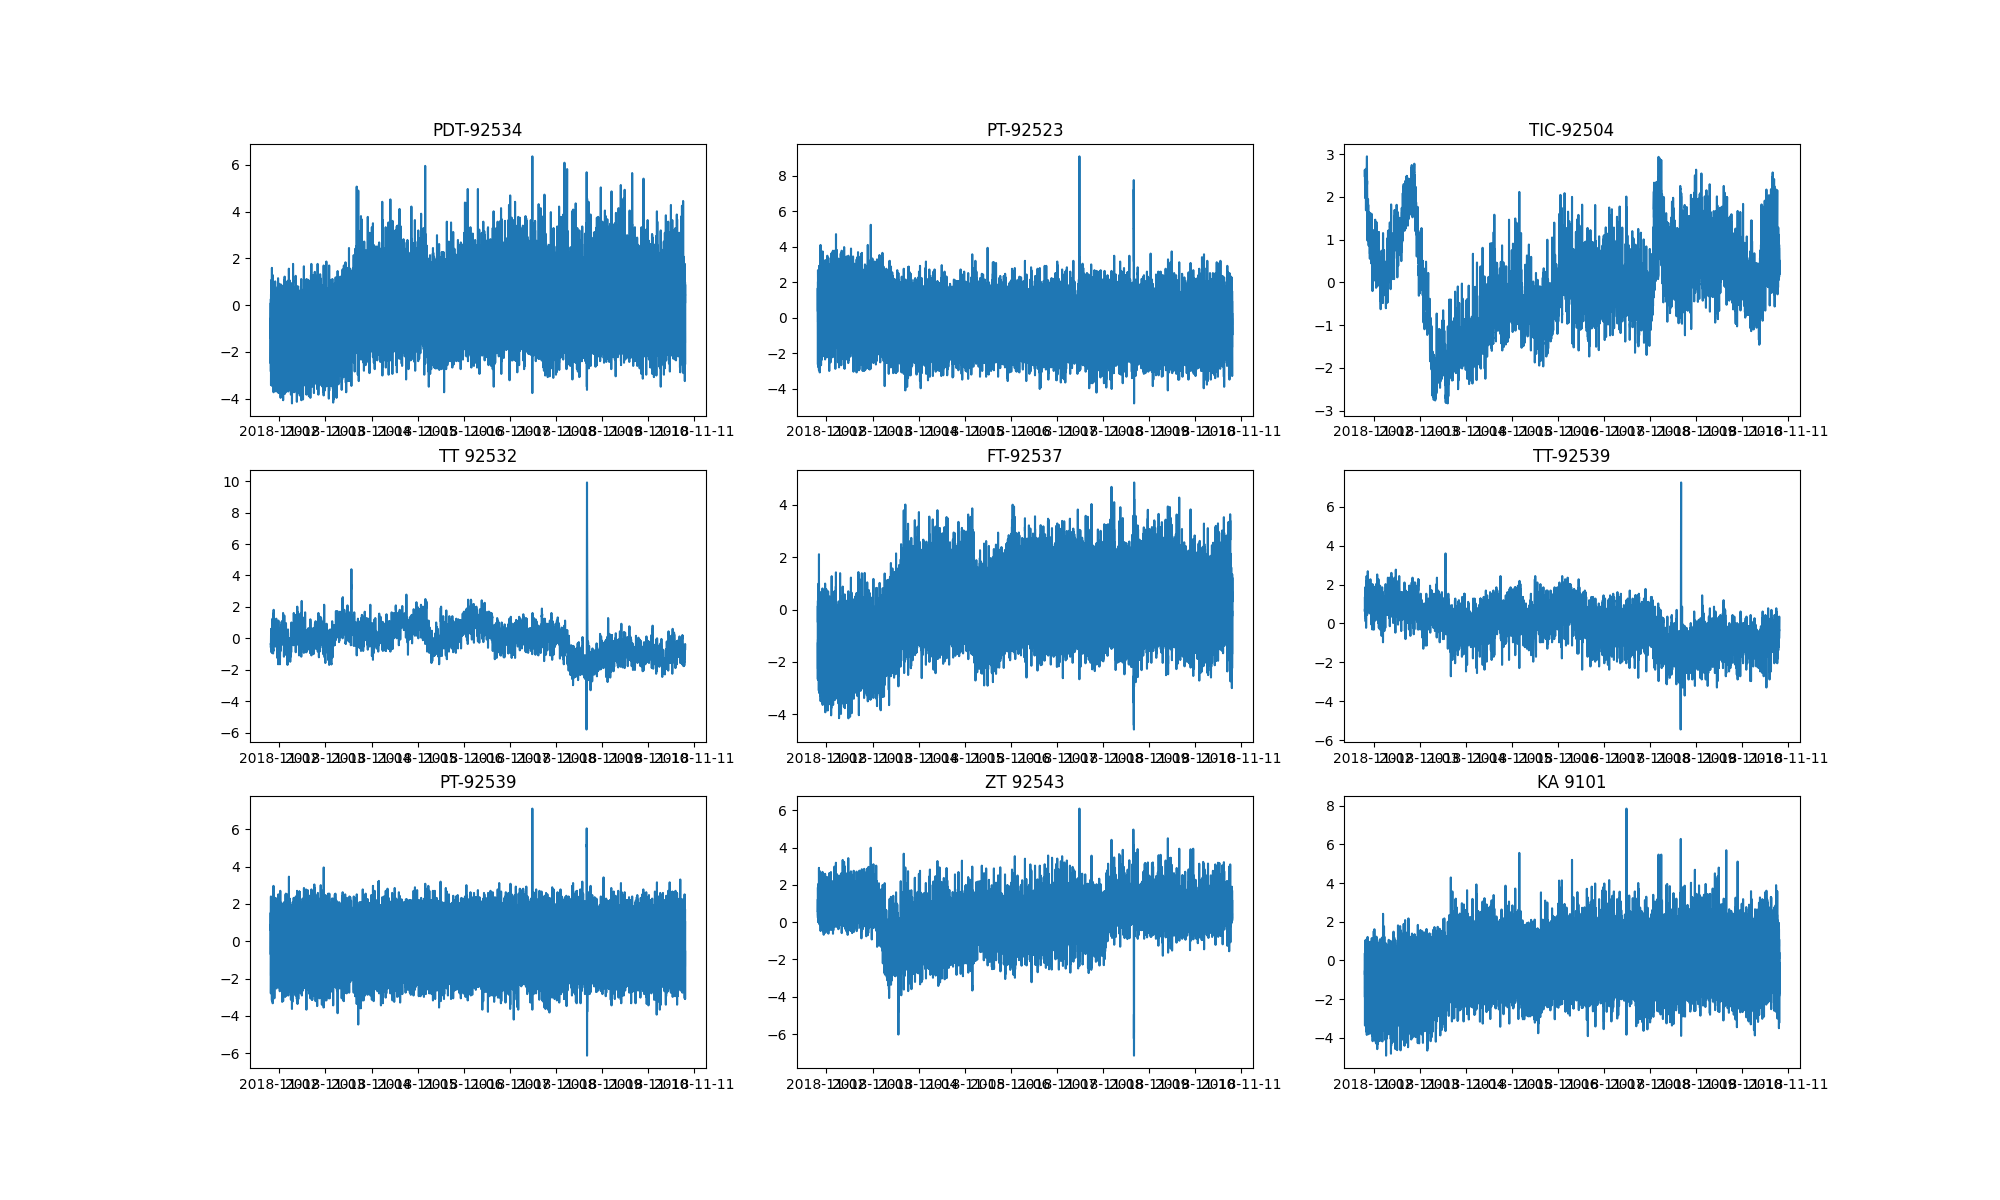

In [ ]:
import numpy as np

standard_df = {}
# k = 6 #width of the range of accepted values

for name, df in dfs_dict.items():
    avg = df.mean().iloc[0]
    std = df.std().iloc[0]
    tmp_df = (df-avg)/std
    print(f'{name}: Avg: {avg} Std: {std} Shape: {tmp_df.shape}')

    # upper = k*std
    # lower = -k*std

    # # Create arrays of Boolean values indicating the outlier rows
    # upper_array = tmp_df.index[tmp_df[tmp_df.columns[0]] >= upper].tolist()
    # lower_array = tmp_df.index[tmp_df[tmp_df.columns[0]] <= lower].tolist()
    
    # # Removing the outliers
    # tmp_df.drop(index=upper_array, inplace=True)
    # tmp_df.drop(index=lower_array, inplace=True)
    
    # Print the new shape of the DataFrame
    # print("New Shape: ", tmp_df.shape)
    standard_df[name] = tmp_df

plot_all_nine_sensors(dataframe=standard_df)

### Compile and plot histograms for each sensor

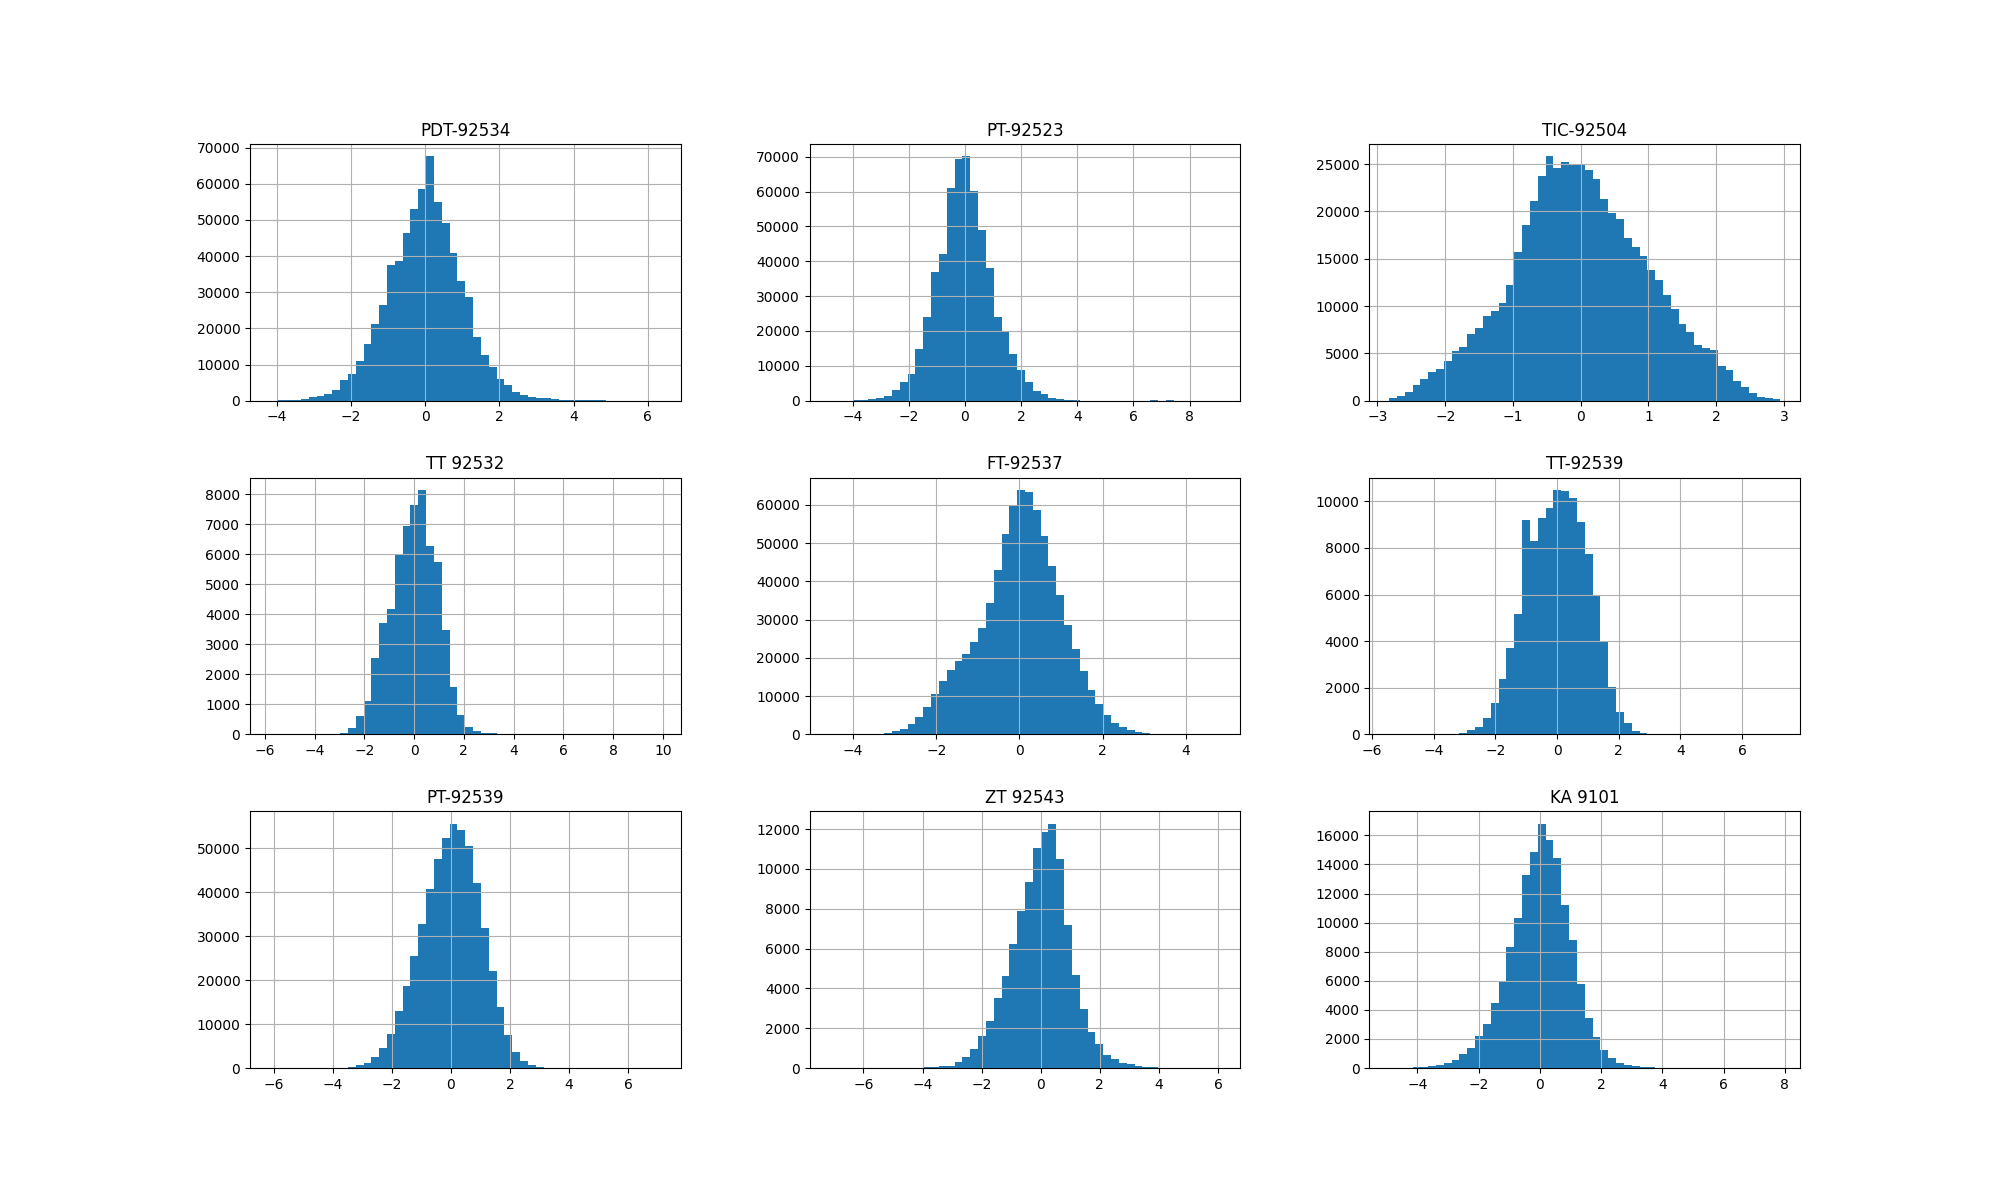

In [ ]:
#Plot histograms
#Using standardized values
names = list(standard_df.keys())
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
bins = 50

m=0
for i in range(3):
    for j in range(3):

        standard_df[names[m]].hist(bins = bins, ax=ax[i,j], figsize=(20, 18))
        ax[i,j].set_title(names[m])
        m+=1



### Finding KL divergence by comparing histograms

Note: you may need to restart the kernel to use updated packages.
[[0.0, 0.30911105489065116, 0.3842703092385725, 0.3878753193140511, 0.39043108725751263, 0.14829299272235033, 0.41813939798052224, inf, inf], [0.23728716445030823, 0.0, 0.8325358643758404, 0.1332306809204912, 0.9994198300866921, 0.5854173370099299, 1.1661246723194738, inf, inf], [0.7311262083934559, 1.8539241136822358, 0.0, 1.954464973452065, 0.374801272300279, 1.1892604921501184, 1.1205085595071949, inf, inf], [0.2151745108605143, 0.11405770546167134, 0.851305041829097, 0.0, 0.9386327882780776, 0.3883007167420502, 0.8441911822259327, inf, inf], [0.4680963782982706, 1.688840608409226, 0.20260364553703075, 1.9237223271367856, 0.0, 0.48456171082009303, 0.23338671946172998, inf, inf], [0.10777189817867795, 0.6429680700457637, 0.45315309379101915, 0.7045166653188568, 0.28438908714304617, 0.0, 0.11176899908219633, inf, inf], [0.31062065858303517, 1.2370136358765988, 0.42966827833323445, 1.41772022692728, 0.14009095307926733, 

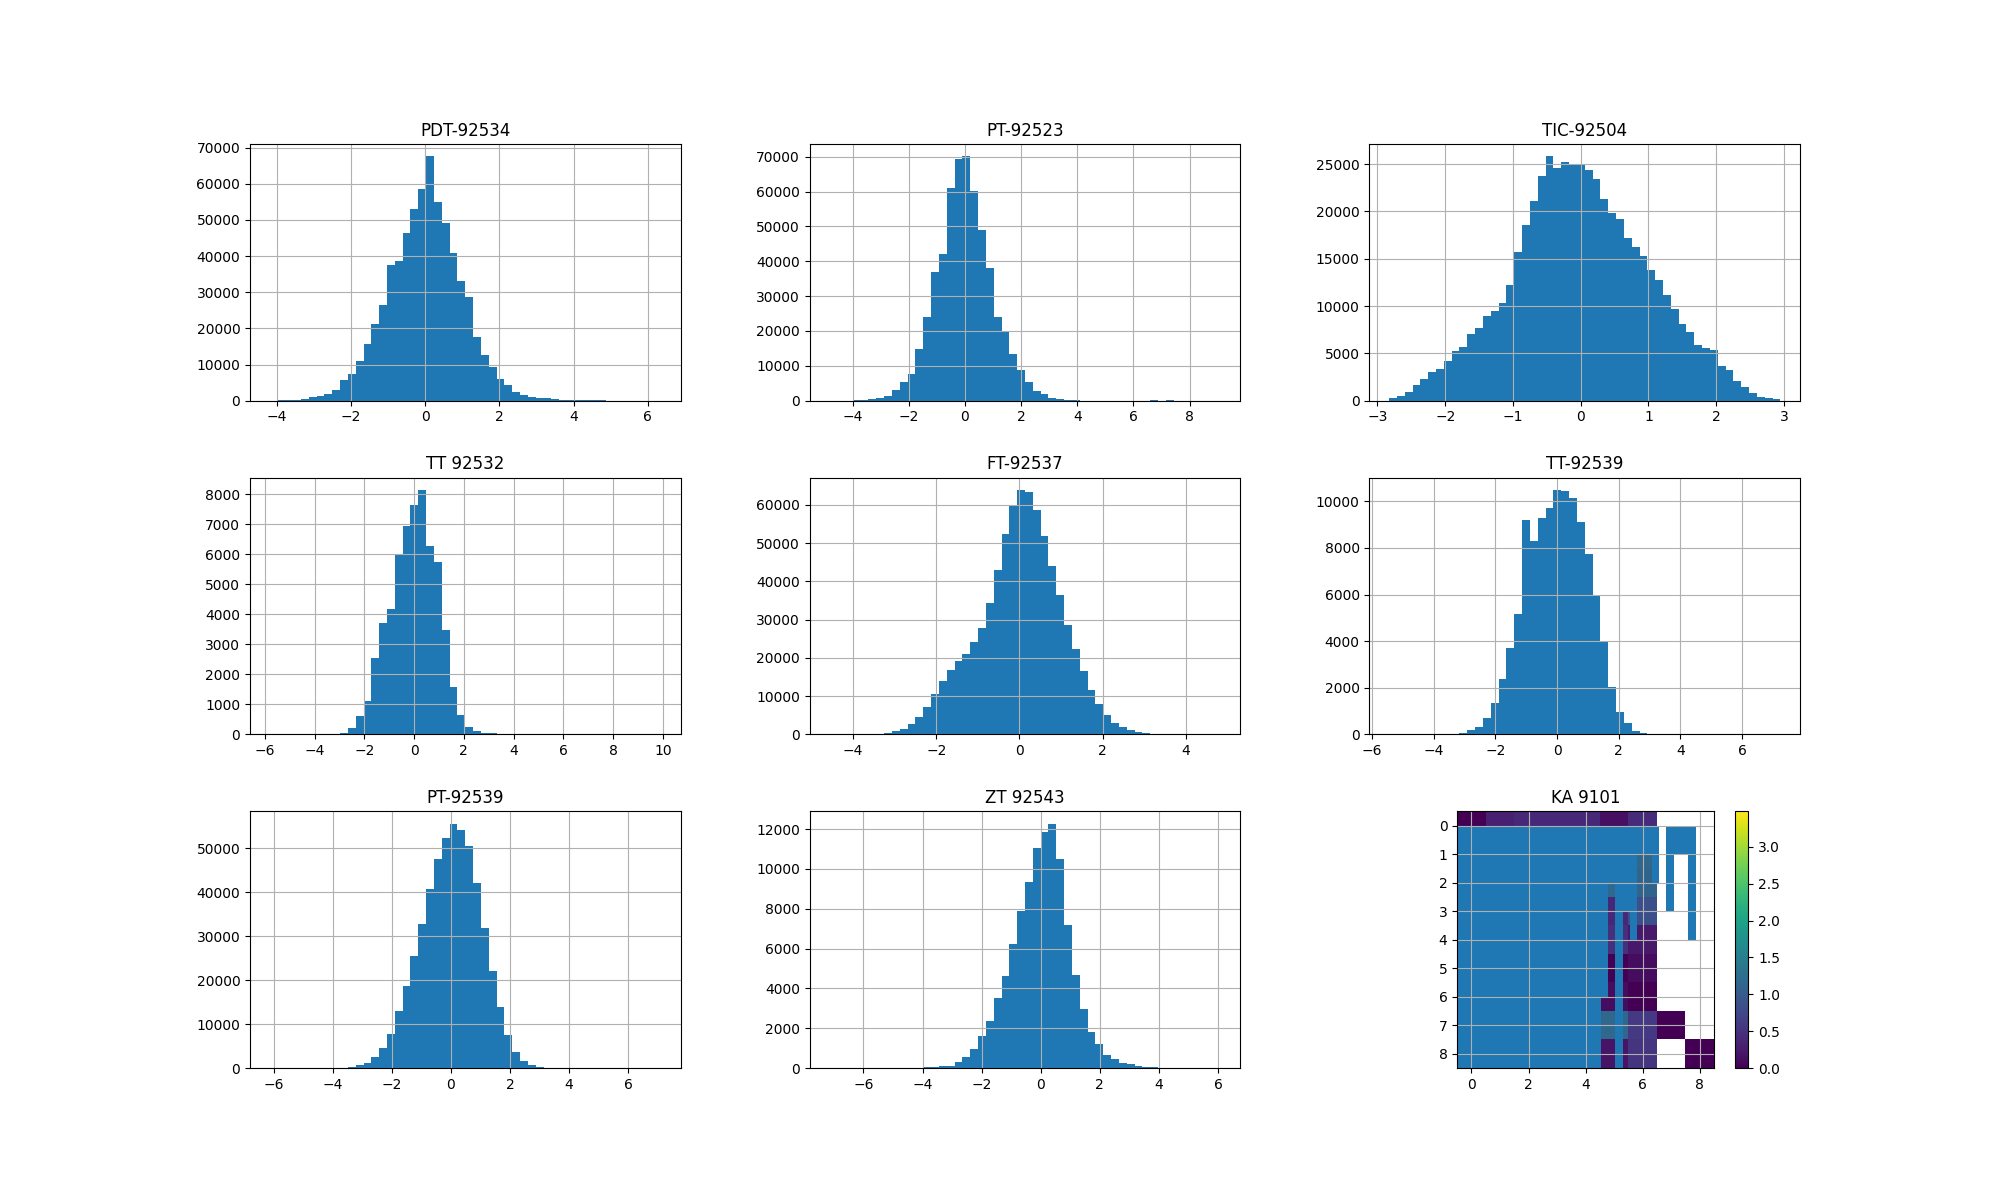

In [ ]:
%pip install scipy
from scipy.stats import entropy
import numpy as np
KL = []

i = 0
j = 0

for name, df in standard_df.items():
    row = []
    hist1 = np.histogram(df, bins=bins)[0]
    hist1 = hist1/sum(hist1)
    for name2, df2 in standard_df.items():
        hist2 = np.histogram(df2, bins=bins)[0]
        hist2 = hist2/sum(hist2)
        # print(f'H1: {type(hist1)}, H2: {type(hist2)}')
        row.append(entropy(hist1, hist2))
    KL.append(row)

print(KL)
im = plt.imshow(KL)
plt.colorbar(im)
plt.show()

### Finding KL divergence from mean and std

We assume that each sensors samples comes from a univariate normal distribution with mean $\mu$ and standard deviation $\sigma$, we can estimate $\mu$ and $\sigma$ from the sample date. We can thn find the KL divergence between 2 estimated distributions by the following formula

$$KL(\mathcal{N}_1(\mu_1, \sigma_1)||\mathcal{N}_2(\mu_2, \sigma_2)) = log(\frac{\sigma_2}{\sigma_1}) + \frac{\sigma_1^2 +(\mu_1-\mu_2)^2}{2 \sigma_2^2}-\frac{1}{2}$$

In [ ]:
import numpy as np
from scipy.stats import entropy

def KL_with_params(m1, std1, m2, std2):
    return np.log(std2/std1)+(std1**2 + (m1-m2)**2)/(2*std2**2)-1/2

# Test the function
mu, sigma = 1, 2
mu2, sigma2 = 0, 2

print(f'Using mean and std directly: KL={KL_with_params(mu, sigma, mu2, sigma2)}')

Using mean and std directly: KL=0.125


Since this method assumes the mean and standard deviation comes from actual normal distributions, standardizing the samples would make all the sample distributions look identical. We therefore have to us unstandardized values with this KL divergence method. Since it's just estimates of mean and standard deviation, the computed KL divergence will not be the actual KL divergence between the sensors behavior, but rather the KL divergence between the sensors estimated source distributions.

[[0.0, 583410.5330177906, 1370.3555129339084, 5989.66296307841, 558.2825550619547, 290.5792524936831, 56041.324959755744, 202.344897635871, 730.1277403851973], [140.45678623838796, 0.0, 450.089833645042, 1003.8391249824854, 564.8396412029341, 11244.946113529346, 624.868038154481, 65.3542655944078, 751.0149285797617], [56.33699173362013, 77374.77503185741, 0.0, 64.78215770797694, 561.3960169732336, 5371.729349378003, 4944.411358562156, 0.5649637284360445, 742.3244000488301], [70.48842453959303, 49253.29327738372, 18.534196944253974, 0.0, 562.1994764238036, 6384.289150793602, 2605.41474931582, 3.2565052728853026, 744.1852548004981], [29669739.505623125, 126633458154.0864, 732870106.1105304, 2575134354.09393, 0.0, 1747767656.2318249, 14856243430.073141, 106196715.00315508, 13582.725385913896], [6.018896352312593, 810545.1818766154, 2244.6249982072704, 9370.671941710318, 559.8911549327744, 0.0, 80340.76615927211, 332.07483267890206, 729.1645251738167], [114.47060260664482, 5321.46618132881

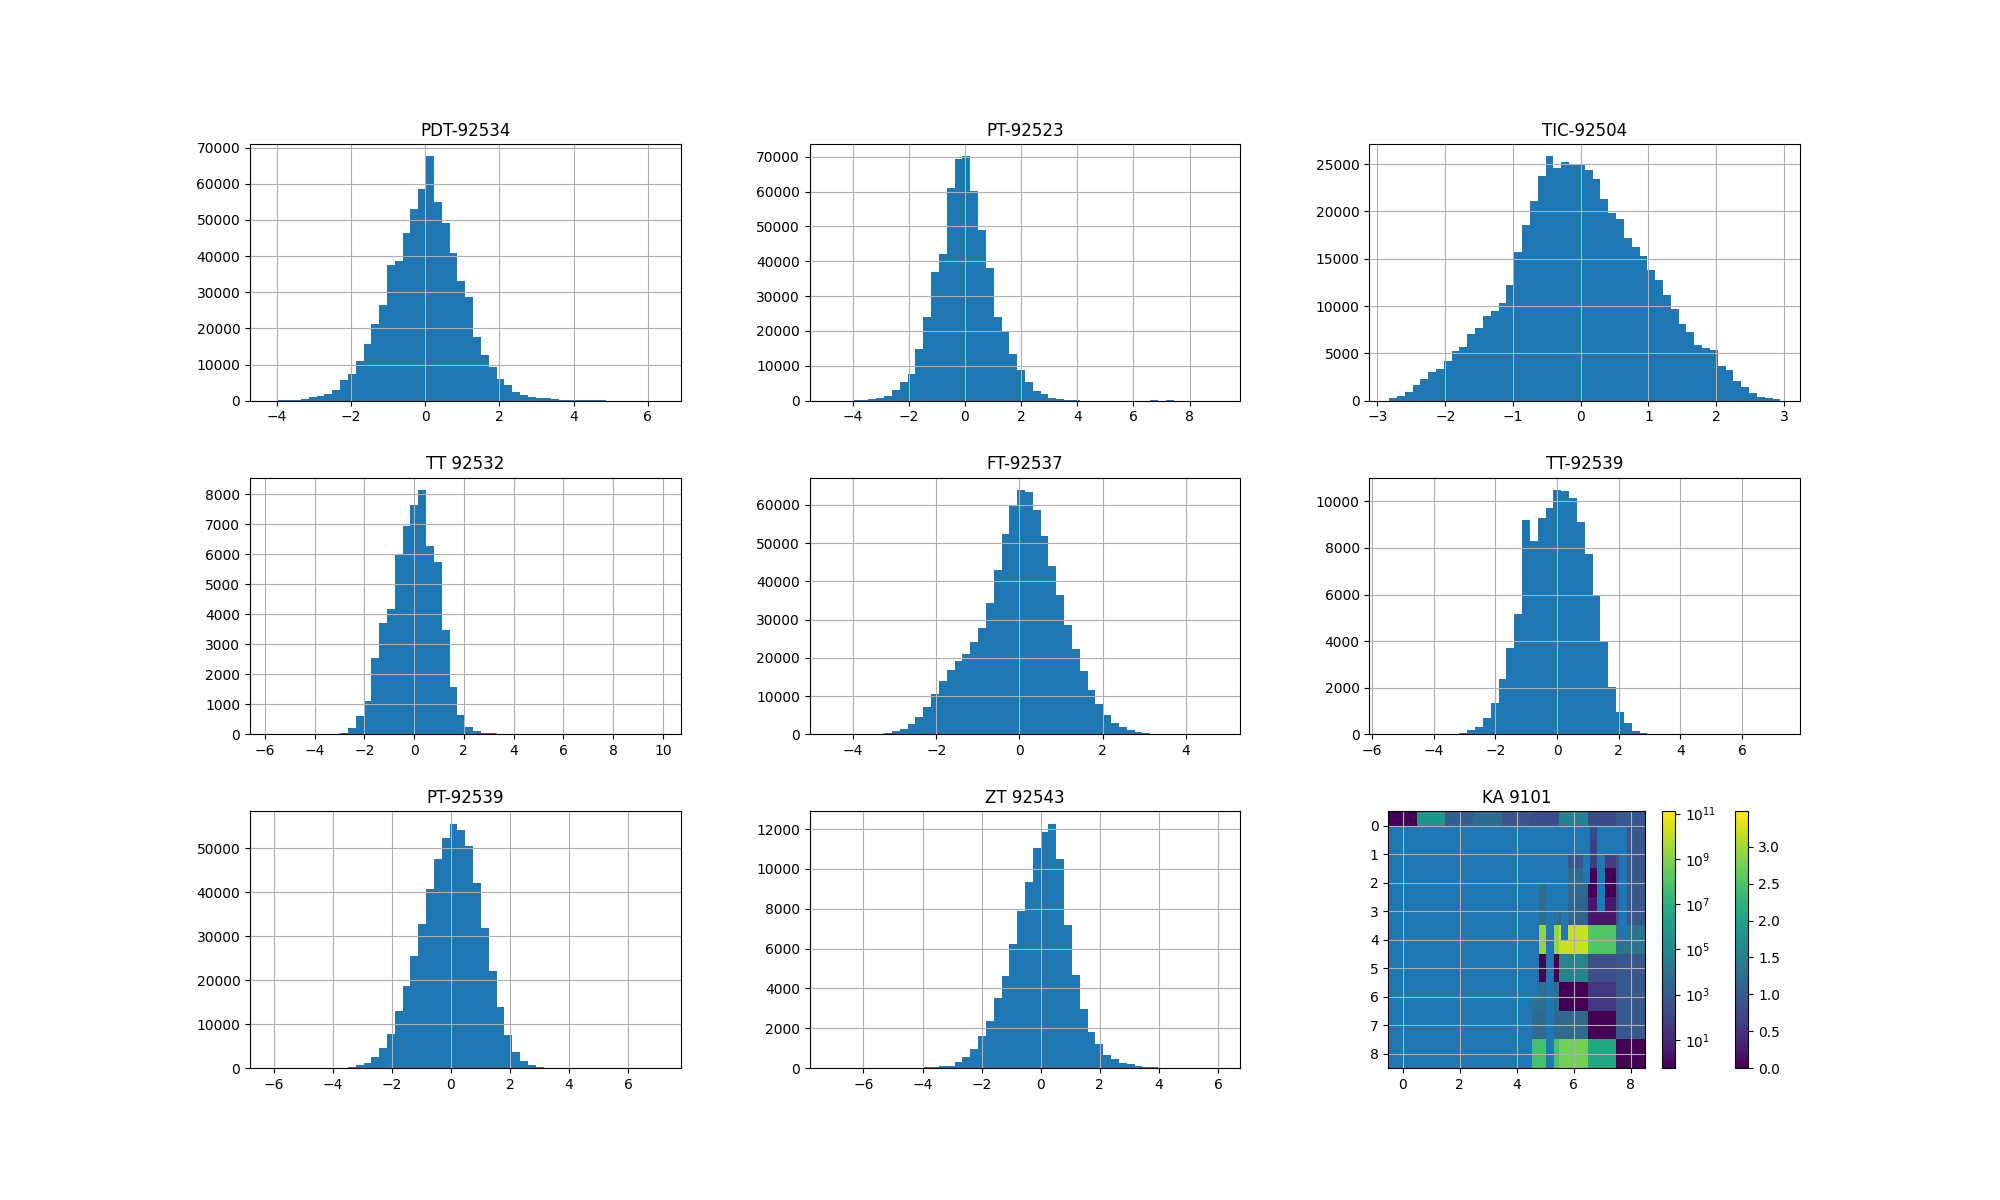

In [ ]:
from matplotlib import colors
KL2 = []

for name, df in dfs_dict.items():
    avg1 = df.mean().iloc[0]
    std1 = df.std().iloc[0]
    row = []
    for name, df in dfs_dict.items():
        avg2 = df.mean().iloc[0]
        std2 = df.std().iloc[0]
        kl_tmp = KL_with_params(avg1, std1, avg2, std2)
        row.append(kl_tmp)
    KL2.append(row)

print(KL2)
im = plt.imshow(KL2, norm=colors.LogNorm())
plt.colorbar(im)
plt.show()

### Correlation between sensors

In [ ]:
# %pip install jinja2
min_len = 10000000000
all_dfs = pd.DataFrame()
for name, df in dfs_dict.items():
    all_dfs[name] = df.dropna()
    if df.shape[0] < min_len: min_len = df.shape[0] 

print(min_len)

corr = all_dfs.corr()
corr.style.background_gradient(cmap='Spectral')

# This is most likely problematic because of the varying lengths of the time series


59666


,PDT-92534,PT-92523,TIC-92504,TT 92532,FT-92537,TT-92539,PT-92539,ZT 92543,KA 9101
PDT-92534,1.000000,0.372774,0.045838,0.030651,0.898062,-0.347894,0.127510,0.125881,0.822831
PT-92523,0.372774,1.000000,0.283718,nan,nan,-0.229320,0.849257,nan,nan
TIC-92504,0.045838,0.283718,1.000000,-0.246755,0.230503,-0.255831,0.056298,0.422847,0.194990
TT 92532,0.030651,nan,-0.246755,1.000000,nan,0.906247,-0.028998,-0.387224,-0.051893
FT-92537,0.898062,nan,0.230503,nan,1.000000,-0.016870,-0.024768,nan,nan
TT-92539,-0.347894,-0.229320,-0.255831,0.906247,-0.016870,1.000000,-0.081498,-0.092957,-0.369334
PT-92539,0.127510,0.849257,0.056298,-0.028998,-0.024768,-0.081498,1.000000,-0.479427,0.593355
ZT 92543,0.125881,nan,0.422847,-0.387224,nan,-0.092957,-0.479427,1.000000,-0.229293
KA 9101,0.822831,nan,0.194990,-0.051893,nan,-0.369334,0.593355,-0.229293,1.000000
